In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from glob import glob


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_msd(folder_path: str, sample_name: str) -> dict:
    """
    Read CSV files with 'time' and 'MSD' columns from folder_path.
    Filter data to time <= 1 second.
    Returns dictionary with sample names as keys and filtered DataFrames as values.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Directory not found: {folder_path}")
    
    data_dict = {}
    files = glob(os.path.join(folder_path, "*.csv"))  # Use glob for path handling
    if not files:
        raise ValueError(f"No CSV files found in {folder_path}")
    
    for i, file_path in enumerate(files):
        try:
            df = pd.read_csv(file_path)
            if not all(col in df.columns for col in ['time', 'MSD']):
                raise ValueError(f"CSV must contain 'time' and 'MSD' columns: {file_path}")
            df = df[['time', 'MSD']]
            df = df[df['time'] <= 1]  # Filter data
            if df.empty:
                print(f"Warning: No data after filtering in {file_path}")
            data_dict[f'{sample_name}_{i + 1}'] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return data_dict

def linear_regression_through_origin(df: pd.DataFrame) -> float:
    """Perform linear regression through the origin (y = mx)."""
    if df.empty:
        return np.nan
    X = df['time'].values
    y = df['MSD'].values
    return np.sum(X * y) / np.sum(X ** 2)  # Slope formula

def fit_msd(data_dict: dict) -> pd.DataFrame:
    """Fit MSD data for all samples and return slopes in a DataFrame."""
    results = []
    for sample_name, df in data_dict.items():
        slope = linear_regression_through_origin(df)
        results.append({'Sample': sample_name, 'Slope': slope})
    return pd.DataFrame(results)

def plot_msd(data_dict: dict, title: str = 'MSD vs Time'):
    """Plot MSD vs time for each sample."""
    plt.figure(figsize=(12, 8))
    for key, df in data_dict.items():
        plt.scatter(df['time'], df['MSD'], label=key)
    plt.xlabel('Time (s)')
    plt.ylabel('MSD')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_msd_fit(data_dict: dict, results_df: pd.DataFrame, title: str = 'MSD vs Time with Linear Fit'):
    """Plot MSD vs time with linear fit lines."""
    plt.figure(figsize=(12, 8))
    for sample_name, df in data_dict.items():
        slope = results_df.loc[results_df['Sample'] == sample_name, 'Slope'].values[0]
        # Get color from scatter plot
        scatter = plt.scatter(df['time'], df['MSD'], label=sample_name)
        color = scatter.get_facecolor()[0] if scatter.get_facecolor().size > 0 else None
        plt.plot(df['time'], slope * df['time'], color=color)
    plt.xlabel('Time (s)')
    plt.ylabel('MSD')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
data_folders = {
    '2p5_Apr5': 'MSD/2p5_Apr5',
    '2p5_HA_Apr5': 'MSD/2p5_HA_Apr5',
    '2p5_Mar22': 'MSD/2p5_Mar22',
    '2p5_HA_Mar6': 'MSD/2p5_HA_Mar6'
}


In [4]:
datasets = {}
for name, path in data_folders.items():
    try:
        datasets[name] = read_msd(path, name)
        print(f"Loaded {len(datasets[name])} files from {name}")
    except Exception as e:
        print(f"Skipping {name}: {e}")

Loaded 9 files from 2p5_Apr5
Loaded 9 files from 2p5_HA_Apr5
Loaded 7 files from 2p5_Mar22
Loaded 5 files from 2p5_HA_Mar6


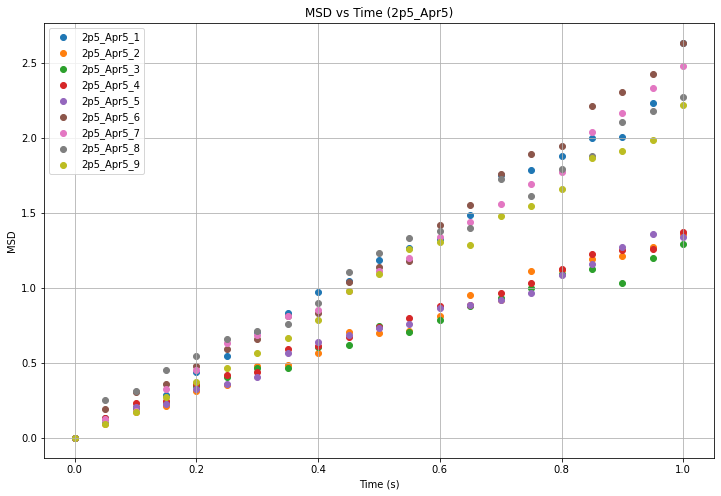

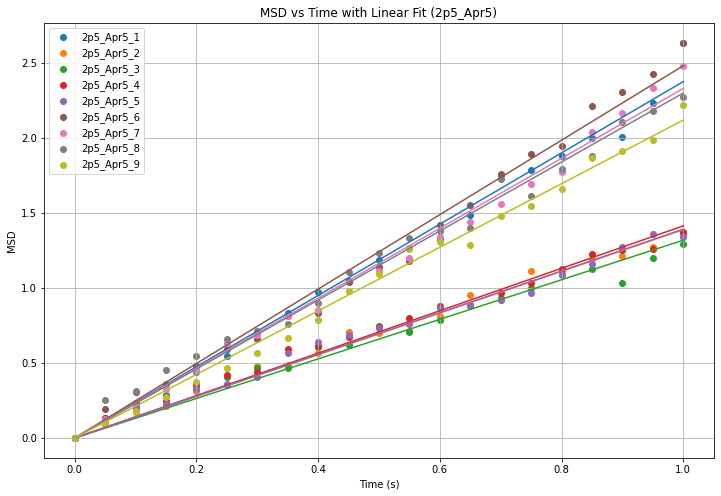

Slopes for 2p5_Apr5:


,Sample,Slope
0,2p5_Apr5_1,2.376038
1,2p5_Apr5_2,1.389220
2,2p5_Apr5_3,1.318843
3,2p5_Apr5_4,1.414187
4,2p5_Apr5_5,1.392491
5,2p5_Apr5_6,2.481828
6,2p5_Apr5_7,2.330734
7,2p5_Apr5_8,2.299894
8,2p5_Apr5_9,2.119475


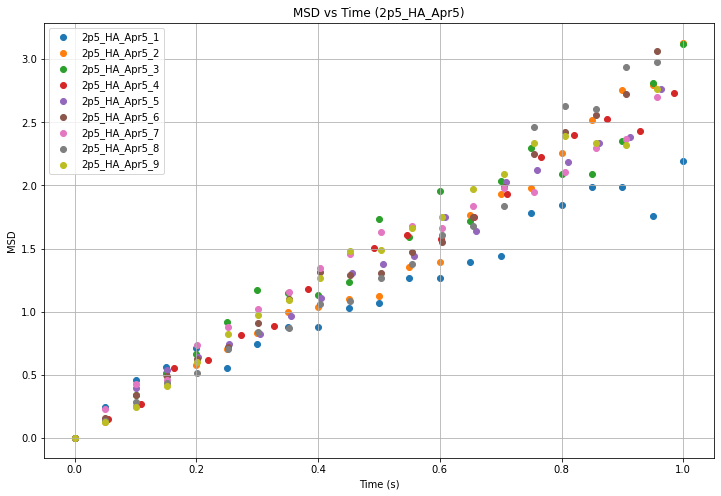

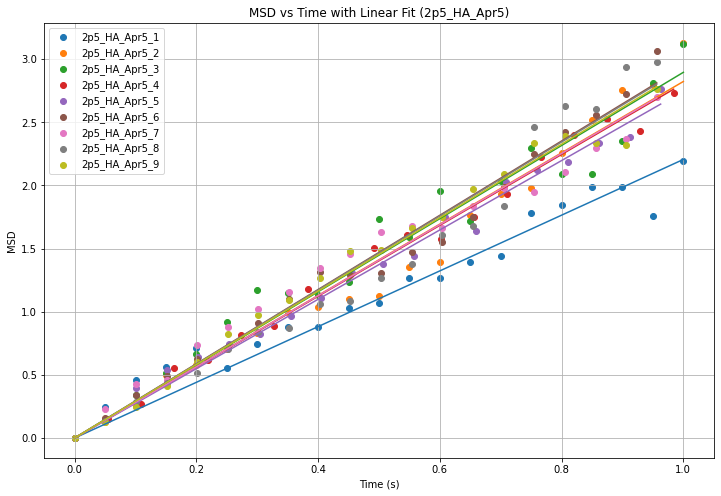

Slopes for 2p5_HA_Apr5:


,Sample,Slope
0,2p5_HA_Apr5_1,2.206252
1,2p5_HA_Apr5_2,2.823622
2,2p5_HA_Apr5_3,2.896188
3,2p5_HA_Apr5_4,2.807325
4,2p5_HA_Apr5_5,2.746888
5,2p5_HA_Apr5_6,2.940526
6,2p5_HA_Apr5_7,2.817080
7,2p5_HA_Apr5_8,2.930545
8,2p5_HA_Apr5_9,2.909044


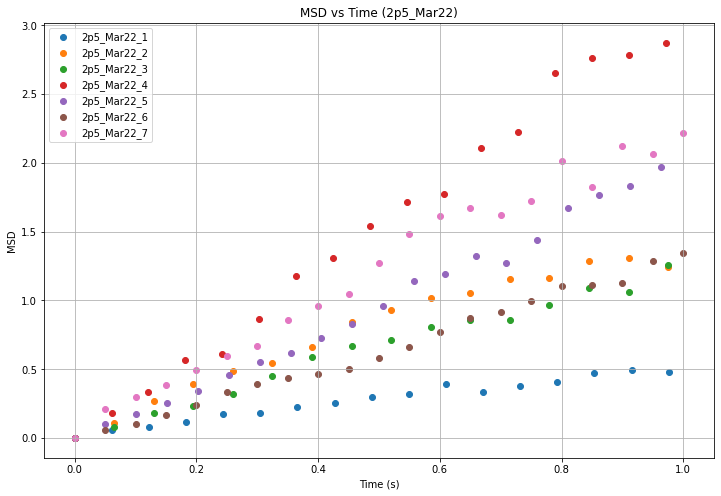

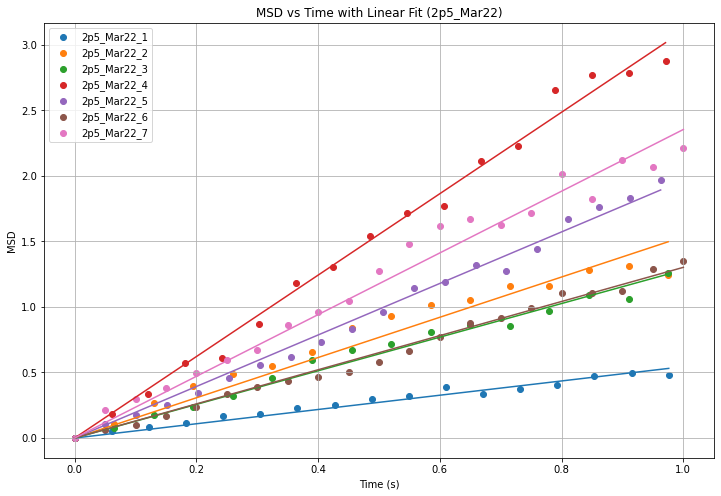

Slopes for 2p5_Mar22:


,Sample,Slope
0,2p5_Mar22_1,0.544287
1,2p5_Mar22_2,1.535285
2,2p5_Mar22_3,1.282424
3,2p5_Mar22_4,3.106489
4,2p5_Mar22_5,1.965351
5,2p5_Mar22_6,1.301931
6,2p5_Mar22_7,2.353413


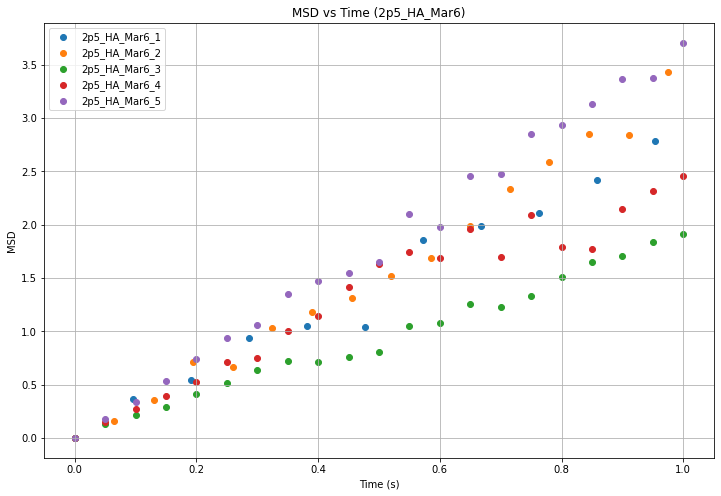

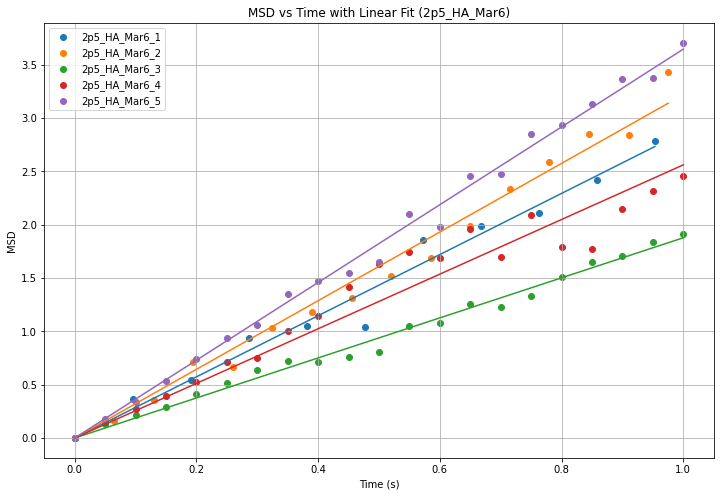

Slopes for 2p5_HA_Mar6:


,Sample,Slope
0,2p5_HA_Mar6_1,2.867027
1,2p5_HA_Mar6_2,3.218925
2,2p5_HA_Mar6_3,1.877556
3,2p5_HA_Mar6_4,2.561279
4,2p5_HA_Mar6_5,3.646038


In [5]:
# Process and plot each dataset
for name, data_dict in datasets.items():
    if not data_dict:
        continue
    plot_msd(data_dict, title=f'MSD vs Time ({name})')
    results_df = fit_msd(data_dict)
    plot_msd_fit(data_dict, results_df, title=f'MSD vs Time with Linear Fit ({name})')
    print(f"Slopes for {name}:")
    display(results_df)  # Show slopes in notebook